* Master DAC, BDLE, 2021 
* Author:Kamel NAIT SLIMANI
* Affiliation: Faculté des Sciences - Sorbonne Université
* Email: kamel.nait_slimani@etu.sorbonne-universite.fr


#Spark Session Préparation

Vérifier que des ressources de calcul sont allouées à votre notebook est connecté (cf RAM  de disque indiqués en haut à droite) . Sinon cliquer sur le bouton connecter pour obtenir des ressources.




Pour accéder directement aux fichiers stockées sur votre google drive. Renseigner le code d'authentification lorsqu'il est demandé

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/dir/DM2"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)


Mounted at /content/drive


['census-income.data.gz',
 'census-income.data',
 'census-income.test.gz',
 'census-income.test',
 'train_data.parquet',
 'test_data.parquet']

Installer pyspark et findspark :


In [2]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 47.4 MB/s 


Démarrer la session spark

In [3]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [4]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "15G").\
  set("spark.driver.memory","25G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1637429432551


In [5]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


In [25]:
import pandas as pd
from google.colab import data_table
import gc
import matplotlib.pyplot as plt

# Alternative to Databricks display function.
pd.options.display.max_colwidth = 400

def display(df, n=10000):
  return data_table.DataTable(df.limit(n).toPandas(), include_index=False, num_rows_per_page=10)


#Data Downloading


In [7]:
import os
from urllib import request
import gzip

url_train =  "http://kdd.ics.uci.edu/databases/census-income/census-income.data.gz"
url_test =  "http://kdd.ics.uci.edu/databases/census-income/census-income.test.gz"
# temp = "/temp"
local_archive_train = drive_dir +"/census-income.data.gz"
local_archive_test = drive_dir +"/census-income.test.gz"
local_train=drive_dir +"/census-income.data"
local_test= drive_dir +"/census-income.test"
os.makedirs(drive_dir,exist_ok=True)


if(os.path.isfile(local_train)):
  print("train data already downloaded")
else:
  print("downloading from URL: ", url_train, "save in : ", local_archive_train)
  request.urlretrieve(url_train, local_archive_train)
  os.chdir(drive_dir)
  print(drive_dir,local_archive_train)
  with  gzip.open(local_archive_train,"rb") as gz_f:
    with open(local_train,"wb") as f:
      f.write(gz_f.read())


if(os.path.isfile(local_archive_test)):
  print("test data already downloaded")
else:
  print("downloading from URL: ", url_test, "save in : ", local_archive_test)
  request.urlretrieve(url_test, local_archive_test)
  os.chdir(drive_dir)
  with  gzip.open(local_archive_test,"rb") as gz_f:
    with open(local_test,"wb") as f:
      f.write(gz_f.read())

#liste des fichier des données 
os.listdir(drive_dir)

train data already downloaded
test data already downloaded


['census-income.data.gz',
 'census-income.data',
 'census-income.test.gz',
 'census-income.test',
 'train_data.parquet',
 'test_data.parquet']

#Data Processing

##Data Loading 

Dans cette section nous avons chercher une base de donées et nous avons crée le dataFrame suivant le schema des données puis enlever des features.

In [30]:
import pandas as pd
import gc
import matplotlib.pyplot as plt


In [31]:
schema="""AAGE float , 
ACLSWKR string , 
ADTIND string , 
ADTOCC string , 
AHGA string , 
AHRSPAY float , 
AHSCOL string , 
AMARITL string , 
AMJIND string , 
AMJOCC string , 
ARACE string , 
AREORGN string , 
ASEX string , 
AUNMEM string , 
AUNTYPE string , 
AWKSTAT string , 
CAPGAIN float , 
CAPLOSS float , 
DIVVAL float , 
FILESTAT string , 
GRINREG string , 
GRINST string , 
HHDFMX string , 
HHDREL string , 
MARSUPWT float,
MIGMTR1 string , 
MIGMTR3 string , 
MIGMTR4 string , 
MIGSAME string , 
MIGSUN string , 
NOEMP float , 
PARENT string , 
PEFNTVTY string , 
PEMNTVTY string , 
PENATVTY string , 
PRCITSHP string , 
SEOTR string , 
VETQVA string , 
VETYN string , 
WKSWORK float , 
YEAR string ,
Label string"""


In [32]:
train_dataset = spark.read.csv(path = drive_dir + "/census-income.data",schema=schema).persist()
test_dataset=spark.read.csv(path = drive_dir + "/census-income.test",schema=schema).persist()

In [33]:
train_dataset.show(5)

+----+--------------------+------+------+--------------------+-------+----------------+--------------+--------------------+--------------------+--------------------+----------+-------+----------------+----------------+--------------------+-------+-------+------+------------------+----------------+----------------+--------------------+--------------------+--------+-----------+------------+------------+--------------------+----------------+-----+--------------------+--------------+--------------+--------------+--------------------+-----+----------------+-----+-------+----+---------+
|AAGE|             ACLSWKR|ADTIND|ADTOCC|                AHGA|AHRSPAY|          AHSCOL|       AMARITL|              AMJIND|              AMJOCC|               ARACE|   AREORGN|   ASEX|          AUNMEM|         AUNTYPE|             AWKSTAT|CAPGAIN|CAPLOSS|DIVVAL|          FILESTAT|         GRINREG|          GRINST|              HHDFMX|              HHDREL|MARSUPWT|    MIGMTR1|     MIGMTR3|     MIGMTR4|        

In [34]:
distinct_values=train_dataset.agg(*(countDistinct(col(c)).alias(c) for c in test_dataset.columns))

In [35]:
distinct_values.show()

+----+-------+------+------+----+-------+------+-------+------+------+-----+-------+----+------+-------+-------+-------+-------+------+--------+-------+------+------+------+--------+-------+-------+-------+-------+------+-----+------+--------+--------+--------+--------+-----+------+-----+-------+----+-----+
|AAGE|ACLSWKR|ADTIND|ADTOCC|AHGA|AHRSPAY|AHSCOL|AMARITL|AMJIND|AMJOCC|ARACE|AREORGN|ASEX|AUNMEM|AUNTYPE|AWKSTAT|CAPGAIN|CAPLOSS|DIVVAL|FILESTAT|GRINREG|GRINST|HHDFMX|HHDREL|MARSUPWT|MIGMTR1|MIGMTR3|MIGMTR4|MIGSAME|MIGSUN|NOEMP|PARENT|PEFNTVTY|PEMNTVTY|PENATVTY|PRCITSHP|SEOTR|VETQVA|VETYN|WKSWORK|YEAR|Label|
+----+-------+------+------+----+-------+------+-------+------+------+-----+-------+----+------+-------+-------+-------+-------+------+--------+-------+------+------+------+--------+-------+-------+-------+-------+------+-----+------+--------+--------+--------+--------+-----+------+-----+-------+----+-----+
|  91|      9|    52|    47|  17|   1240|     3|      7|    24|    15|   

In [36]:
Not_in_Universe_count=pd.DataFrame([[train_dataset.where(col(column).contains("Not in universe")).count() for column in test_dataset.columns]],columns= test_dataset.columns)

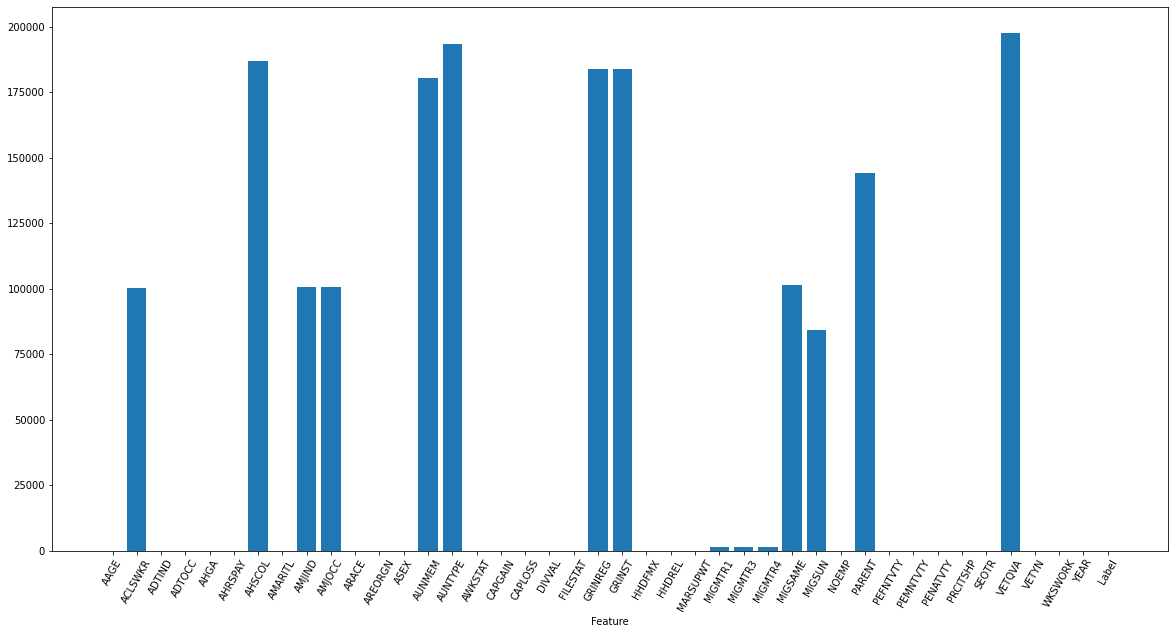

In [37]:

fig=plt.figure(figsize=(20,10))
plt.xticks(range(0,len(Not_in_Universe_count.columns)),Not_in_Universe_count.columns)
plt.xlabel("Feature")
plt.bar(Not_in_Universe_count.columns,Not_in_Universe_count.values.reshape(-1))
plt.xticks(rotation=60)
plt.show()

In [38]:
cols_to_remove=Not_in_Universe_count[Not_in_Universe_count.columns[(Not_in_Universe_count>100000).T[0]] ].columns

In [39]:
test_dataset=test_dataset.drop(*cols_to_remove)
train_dataset=train_dataset.drop(*cols_to_remove)
test_dataset=test_dataset.dropDuplicates()
train_dataset=train_dataset.dropDuplicates()

In [40]:
col_to_filter=Not_in_Universe_count[Not_in_Universe_count.columns[((Not_in_Universe_count<100000).T[0] &  (Not_in_Universe_count>0).T[0]) ] ].columns

In [41]:
def filter_dataset_Not_in_universe(df,col_to_filter):
  for column in col_to_filter:
    print("Removing 'Not in universe' Rows in"+column)
    df=df.filter(~col(column).contains("Not in universe"))
  return df

In [42]:
train_dataset=filter_dataset_Not_in_universe(train_dataset,col_to_filter)

Removing 'Not in universe' Rows inMIGMTR1
Removing 'Not in universe' Rows inMIGMTR3
Removing 'Not in universe' Rows inMIGMTR4
Removing 'Not in universe' Rows inMIGSUN


In [43]:
test_dataset=filter_dataset_Not_in_universe(test_dataset,col_to_filter)

Removing 'Not in universe' Rows inMIGMTR1
Removing 'Not in universe' Rows inMIGMTR3
Removing 'Not in universe' Rows inMIGMTR4
Removing 'Not in universe' Rows inMIGSUN


<Figure size 8640x8640 with 0 Axes>

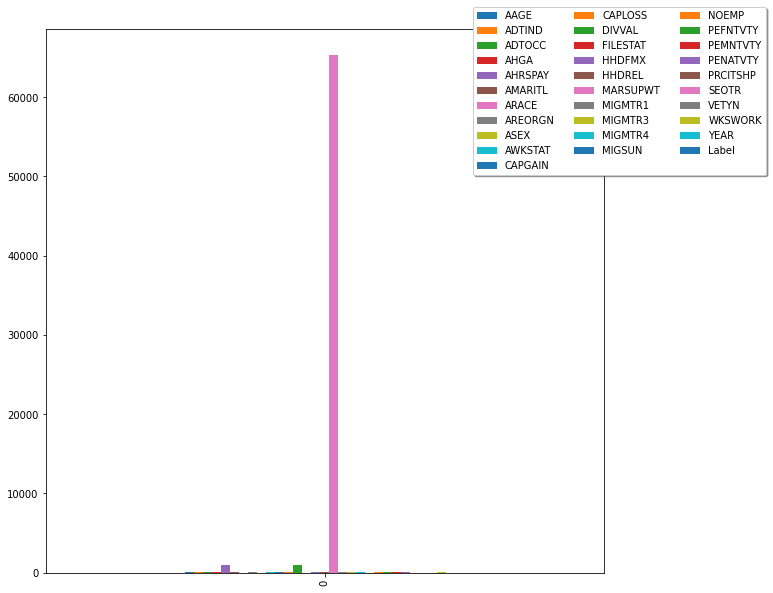

In [44]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(120,120))
distinct_values=train_dataset.agg(*(countDistinct(col(c)).alias(c) for c in test_dataset.columns))
histogram = distinct_values.rdd.histogram(1)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
print()
pd.DataFrame(
    [list(histogram[0][0])],columns=distinct_values.columns
).plot(kind='bar',figsize=(10,10))
plt.legend( bbox_to_anchor=(1.3, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

##Data Transformation
Dans cette section nous avons éffectué des transformation:


In [46]:
from pyspark.ml.feature import MinMaxScaler,VectorIndexer , VectorAssembler,StringIndexer 
from pyspark.ml import Pipeline

####Function pour normaliser une colonnes du data frame.

In [28]:
def normalizer(col):
  assembler=VectorAssembler(inputCols=[col],outputCol="vect_"+col)
  scaler=MinMaxScaler(inputCol="vect_"+col,outputCol="scal_"+col)
  return Pipeline(stages=[assembler, scaler])

In [47]:
string_columns=[ c.split(" ")[0]  for c in  schema.split('\n') if c.split(" ")[1]=="string" and c.split(" ")[0] not in cols_to_remove ]
continous_columns=[ c.split(" ")[0]  for c in  schema.split('\n') if c.split(" ")[1]=="float" and c.split(" ")[0] not in cols_to_remove ]
label = 'Label'
features_col= string_columns
features_col.remove(label)
index_prefix = 'indexed_'

label_string_indexer= StringIndexer(inputCol=label, outputCol=index_prefix+label)

features_str_col= list(map(lambda c:index_prefix+c, features_col))

features_string_indexer= StringIndexer(inputCols=features_col,outputCols=features_str_col)

#Columns values normalizers to have values between 0-1
features_normalizers = [ normalizer(c) for c in (features_string_indexer.getOutputCols()+continous_columns) ]

Scal_cols=[ "scal_"+c for c in (features_string_indexer.getOutputCols()+continous_columns)]

vec_assembler= VectorAssembler(inputCols=Scal_cols,outputCol= 'vector')
vec_indexer= VectorIndexer(inputCol='vector',outputCol='features')

In [48]:
from pyspark.ml import Pipeline
stages = [label_string_indexer,features_string_indexer]
stages.extend(features_normalizers)
stages.extend([vec_assembler,vec_indexer])
pipeline = Pipeline(stages = stages)

####Transformation des données d'entrée avec les pipelines definits

In [107]:
train_data= pipeline.fit(train_dataset).transform(train_dataset)

In [296]:
test_data= pipeline.fit(test_dataset).transform(test_dataset)

####Libération de mémoire
Aprés avoir eu des problémes de saturation mémoire nous avont utilisé le garbage collector de python et de spark pour ne pas saturer la mémoire.

In [297]:
train_dataset,test_dataset=None,None
gc.collect()
spark.sparkContext._jvm.System.gc()

##Data Statistics and dashboards

In [298]:
description=train_data.select(features_string_indexer.getOutputCols()+continous_columns).describe()

In [299]:
description.toPandas()

,summary,indexed_ADTIND,indexed_ADTOCC,indexed_AHGA,indexed_AMARITL,indexed_ARACE,indexed_AREORGN,indexed_ASEX,indexed_AWKSTAT,indexed_FILESTAT,indexed_HHDFMX,indexed_HHDREL,indexed_MIGMTR1,indexed_MIGMTR3,indexed_MIGMTR4,indexed_MIGSUN,indexed_PEFNTVTY,indexed_PEMNTVTY,indexed_PENATVTY,indexed_PRCITSHP,indexed_SEOTR,indexed_VETYN,indexed_YEAR,AAGE,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,WKSWORK
0,count,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202,113202
1,mean,5.763104892139715,6.773678910266603,3.0712884931361635,0.8498701436370382,0.2949859543117613,0.3980760057242805,0.47897563647285385,1.1037967527075494,1.1030105475168284,2.2470981078072825,1.3062225049027403,0.23269023515485593,0.2497570714298334,0.2643416194060176,0.18986413667603047,1.7151375417395451,1.701418702849773,1.0333297998268582,0.19476687691030195,0.1225243370258476,0.24139149484991432,0.13888447200579496,34.156923022561436,56.54419533223795,444.68028833412836,37.742760728609035,189.5134803272027,2.068488189254607,23.956334693733325
2,stddev,9.623414271554694,10.170134089740424,3.5744627275199483,1.045841712623933,0.7544096801420754,1.180955721463259,0.49955998708319693,1.1873411308150408,1.1582796597807439,3.1120909861078423,1.4178437150251362,0.7456537821698227,0.7876531648793718,0.8743552742542083,0.5057443376825311,5.405269826986595,5.38190019520885,4.304101422840034,0.6079233196769637,0.3711129489166722,0.4501622534899045,0.34582745976881374,21.687157719545663,272.02303823229624,4764.279551058104,274.0490140243587,1961.8583660280099,2.4038474618865666,24.367246778100174
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,51.0,46.0,16.0,6.0,4.0,9.0,1.0,7.0,5.0,35.0,7.0,7.0,6.0,7.0,2.0,42.0,42.0,42.0,4.0,2.0,2.0,1.0,90.0,9800.0,99999.0,4608.0,99999.0,6.0,52.0


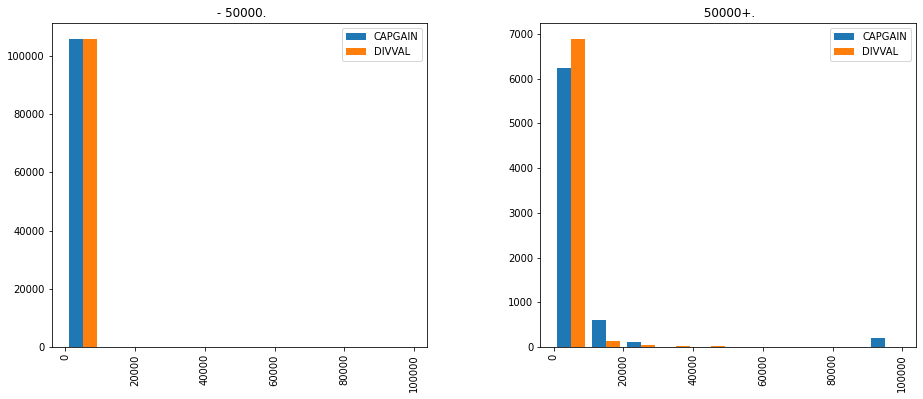

In [109]:
train_data.select("Label","CAPGAIN","DIVVAL").toPandas().hist(figsize=(15,6),by="Label",column=["CAPGAIN","DIVVAL"],legend=True)
plt.legend()
plt.show()

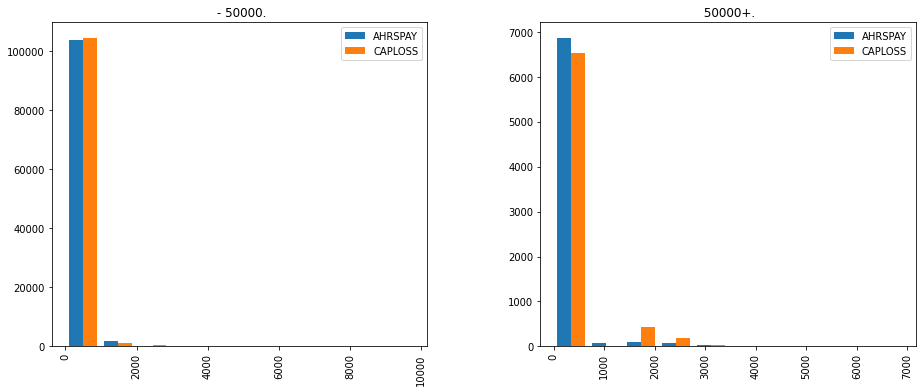

In [108]:
train_data.select("Label","AHRSPAY","CAPLOSS").toPandas().hist(figsize=(15,6),by="Label",column=["AHRSPAY","CAPLOSS"],legend=True)
plt.legend()
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5065eea790>,
      dtype=object)

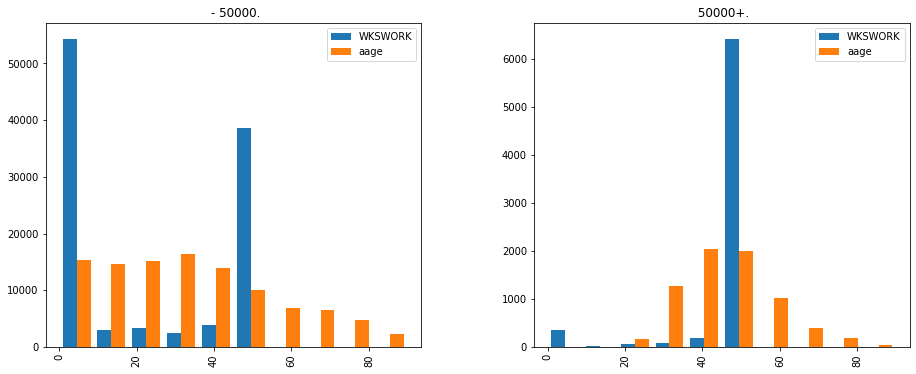

In [110]:
train_data.select("Label","WKSWORK","aage").toPandas().hist(figsize=(15,6),by="Label",column=["WKSWORK","aage"],legend=True)

In [226]:
train_data.select("Label","ASEX").groupBy("ASEX","Label").count().toPandas() 	

,ASEX,Label,count
0,Female,50000+.,1565
1,Female,- 50000.,57416
2,Male,- 50000.,48625
3,Male,50000+.,5596


####Normalized Features
Les features aprés la noramlization

In [304]:
train_data.select(Scal_cols).show()

+--------------------+--------------------+-----------------+--------------------+------------------+--------------------+-----------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+---------------------+---------------------+---------------------+------------------+------------------+-----------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
| scal_indexed_ADTIND| scal_indexed_ADTOCC|scal_indexed_AHGA|scal_indexed_AMARITL|scal_indexed_ARACE|scal_indexed_AREORGN|scal_indexed_ASEX|scal_indexed_AWKSTAT|scal_indexed_FILESTAT| scal_indexed_HHDFMX| scal_indexed_HHDREL|scal_indexed_MIGMTR1|scal_indexed_MIGMTR3|scal_indexed_MIGMTR4|scal_indexed_MIGSUN|scal_indexed_PEFNTVTY|scal_indexed_PEMNTVTY|scal_indexed_PENATVTY|scal_indexed_PRCITSHP|scal_indexed

##Data features label Selection

In [118]:
train_data=train_data.select('features','indexed_Label')

In [119]:
test_data=test_data.select('features','indexed_Label')

In [120]:
gc.collect()
spark.sparkContext._jvm.System.gc()

##Transformed_data saving
Nous sauvegardons les features et les labels de train et de test si on a un probléme pour ne pas exécuter tout le pipeline à chaque si la session se bloque

In [308]:
!rm -r /content/drive/MyDrive/ens/bdle/dir/DM2/train_data.parquet
train_data.write.save(drive_dir+"/train_data.parquet")

In [309]:
!rm -r /content/drive/MyDrive/ens/bdle/dir/DM2/test_data.parquet
test_data.write.save(drive_dir+"/test_data.parquet")

##Transformed Data Loading

In [27]:
train_data= spark.read.load(drive_dir+"/train_data.parquet")
test_data=spark.read.load(drive_dir+"/test_data.parquet")

##Data Balancing
Pour êtres dans la limite des données demandée nous avons fait un undersampling sur la classes majoritaire dans les données de train et de test

In [8]:
train_Positive_class = train_data.filter(col("indexed_Label") == 1 )
train_Negative_class =train_data.filter(col("indexed_Label") == 0 )
test_Positive_class=test_data.filter(col("indexed_Label") == 1 )
test_Negative_class=test_data.filter(col("indexed_Label") ==  0 )

In [9]:
minor_class_train=int(train_Positive_class.count())
train_ratio = int(train_Negative_class.count()/minor_class_train)
test_ratio=int(test_Negative_class.count()/test_Positive_class.count())
print("train ratio: {}, test ratio: {}".format(train_ratio,test_ratio))

train ratio: 14, test ratio: 14


In [10]:
train_data_balanced_by_under_Sampling=train_Positive_class.unionAll(train_Negative_class.sample(False, 1/train_ratio))

df=train_Positive_class
for x in range(int(train_ratio*0.95)):
  df=df.unionAll(train_Positive_class)
train_data_balanced_by_over_Sampling=df.unionAll(train_Negative_class)

df=train_Positive_class
for x in range(int(train_ratio/7)):
  df=df.unionAll(train_Positive_class)
train_data_by_OverandUnder_Sampling=df.unionAll(train_Negative_class.sample(0.5))

In [14]:
#Pour qu'il garde pas les données en Ram
train_Positive_class,train_Negative_class,test_Positive_class,test_Negative_class=None,None,None,None
gc.collect()
spark.sparkContext._jvm.System.gc()

In [18]:
train_data.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,7161
1,0.0,106041


In [15]:
train_data_balanced_by_under_Sampling.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,7161
1,0.0,7468


In [19]:
test_data.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,3656
1,0.0,53367


In [16]:
train_data_by_OverandUnder_Sampling.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,21483
1,0.0,53037


In [17]:
train_data_balanced_by_over_Sampling.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,100254
1,0.0,106041


#Training And Testing Models

In [20]:
from pyspark.ml.classification import RandomForestClassifier ,LinearSVC,GBTClassifier
from  pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

In [21]:
def predict_(model,data_test,col_features="features"):
  return model.transform(
      data_test.select(col_features,"indexed_Label").withColumnRenamed("indexed_Label","label")
      ).select("label","prediction")


In [22]:
def eval_Model(predictions):
  #Preppate test data
  mytrics=["accuracy","weightedPrecision","weightedRecall","fMeasureByLabel"]
  evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel=1, beta=1.0) 
  evalulations={}
  for mytric in mytrics:
    evaluator.setMetricName(mytric)
    evalulations[mytric]=evaluator.evaluate(predictions)
  return evalulations

##Train and Test with unbalanced data



###Random Forest Perforamances


In [347]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data),test_data))

{'accuracy': 0.9379548603195202,
 'fMeasureByLabel': 0.07333682556312206,
 'weightedPrecision': 0.933422613100567,
 'weightedRecall': 0.9379548603195201}

###SVM Model Performances

In [323]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data),test_data))

{'accuracy': 0.9392350455079529,
 'fMeasureByLabel': 0.11267605633802817,
 'weightedPrecision': 0.9358924415548626,
 'weightedRecall': 0.9392350455079529}

###Gradient Boost Model Performances

In [324]:
eval_Model(predict_(GBTClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data),test_data))

{'accuracy': 0.9469161566385493,
 'fMeasureByLabel': 0.43133571294382866,
 'weightedPrecision': 0.9376368195223541,
 'weightedRecall': 0.9469161566385493}

##Train and Test with balanced data


In [325]:
gc.collect()
spark.sparkContext._jvm.System.gc()

###By Under Sampling



####Random Forest Perforamances


In [326]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_under_Sampling),test_data))

{'accuracy': 0.7718990582747313,
 'fMeasureByLabel': 0.3355300127713921,
 'weightedPrecision': 0.9406420115367441,
 'weightedRecall': 0.7718990582747313}

####SVM Model Performances

In [327]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_under_Sampling),test_data))

{'accuracy': 0.8079546849516862,
 'fMeasureByLabel': 0.364459404561546,
 'weightedPrecision': 0.9396008579675283,
 'weightedRecall': 0.8079546849516862}

####Gradient Boost Model Performances

In [328]:
eval_Model(predict_(GBTClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_under_Sampling),test_data))

{'accuracy': 0.8376795328200901,
 'fMeasureByLabel': 0.407122726108122,
 'weightedPrecision': 0.9430012545547024,
 'weightedRecall': 0.8376795328200901}

###By Over Sampling



####Random Forest Perforamances


In [26]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_over_Sampling),test_data))

{'accuracy': 0.7681987969766585,
 'fMeasureByLabel': 0.33423995164702325,
 'weightedPrecision': 0.941270315185325,
 'weightedRecall': 0.7681987969766585}

####SVM Model Performances

In [27]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_over_Sampling),test_data))

{'accuracy': 0.8073233607491714,
 'fMeasureByLabel': 0.3631093849631905,
 'weightedPrecision': 0.9393637916424984,
 'weightedRecall': 0.8073233607491714}

####Gradient Boost Model Performances

In [28]:
eval_Model(predict_(GBTClassifier(maxBins=27,maxDepth=8,featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_over_Sampling),test_data))

{'accuracy': 0.8621959560177472,
 'fMeasureByLabel': 0.440711743772242,
 'weightedPrecision': 0.9437432268750665,
 'weightedRecall': 0.8621959560177472}

###By Under Sampling for majoritary Class and Over Sampling for minority Class



####Random Forest Perforamances


In [373]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_by_OverandUnder_Sampling),test_data))

{'accuracy': 0.9138768567069429,
 'fMeasureByLabel': 0.494493051981472,
 'weightedPrecision': 0.9382747188999763,
 'weightedRecall': 0.9138768567069429}

####SVM Model Performances

In [81]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data_by_OverandUnder_Sampling),test_data))

{'accuracy': 0.8940427546779369,
 'fMeasureByLabel': 0.4578248384781048,
 'weightedPrecision': 0.9368507113766582,
 'weightedRecall': 0.8940427546779369}

####Gradient Boost Model Performances

In [51]:
model=GBTClassifier(maxBins=25,maxDepth=7,labelCol="indexed_Label").fit(train_data_by_OverandUnder_Sampling)

####Importances des features avec le meilleur classfieur 

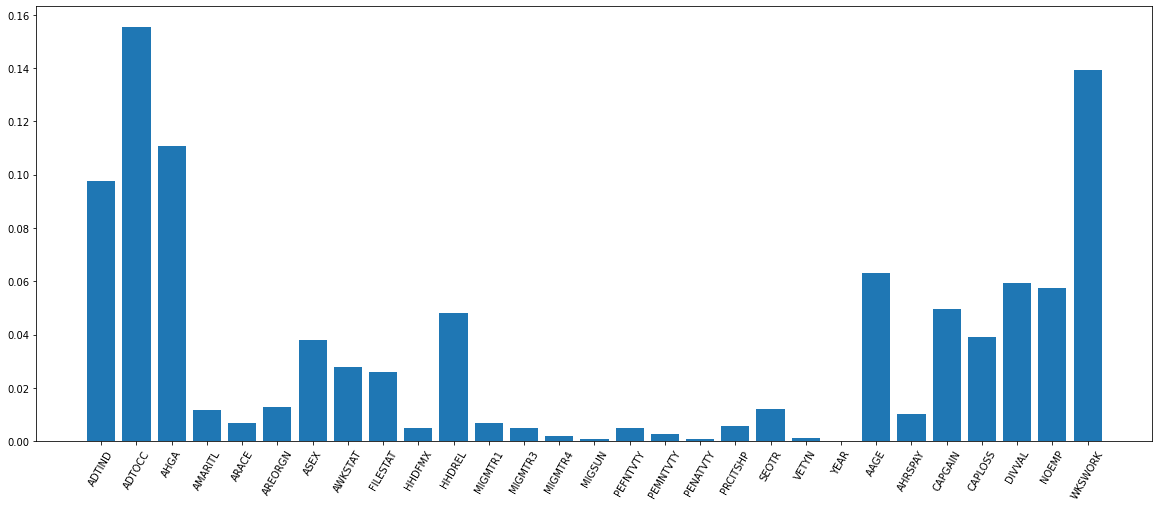

In [52]:
fig=plt.figure(figsize=(20,8))
plt.bar(string_columns+continous_columns,[val for val in model.featureImportances])
plt.xticks(rotation=60)
plt.show()

In [53]:
eval_Model(predict_(model,test_data))

{'accuracy': 0.9148413797941182,
 'fMeasureByLabel': 0.5223293330710211,
 'weightedPrecision': 0.9434874466004213,
 'weightedRecall': 0.9148413797941182}

##Train and test With features selection 

In [378]:
gc.collect()
spark.sparkContext._jvm.System.gc()

###Features selection with Threshold Variance
Aprés les expériences nous avons remarqué que avoir les toutes les propriétées dans les données nous aide a mieux faire la classification.

In [33]:
from pyspark.ml.feature import VarianceThresholdSelector

selector = VarianceThresholdSelector(varianceThreshold=0.5, outputCol="selectedFeatures").fit(train_data_by_OverandUnder_Sampling)



In [34]:
cleaned_data_train = selector.transform(train_data_by_OverandUnder_Sampling).\
select("selectedFeatures","indexed_label").\
withColumnRenamed("selectedFeatures","features")

print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())
cleaned_data_train.select("features","indexed_label").show(5)

Output: Features with variance lower than 0.500000 are removed.
+--------------------+-------------+
|            features|indexed_label|
+--------------------+-------------+
|(9,[0,4,8],[1.0,1...|          1.0|
|(9,[0,3,4,6,7,8],...|          1.0|
|(9,[0,4,8],[1.0,1...|          1.0|
|(9,[0,3,4],[3.0,2...|          1.0|
|(9,[0,1,4,8],[5.0...|          1.0|
+--------------------+-------------+
only showing top 5 rows



In [35]:
cleaned_data_test = selector.transform(test_data).\
select("selectedFeatures","indexed_label").\
withColumnRenamed("selectedFeatures","features")

print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())
cleaned_data_test.select("features","indexed_label").show(5)

Output: Features with variance lower than 0.500000 are removed.
+--------------------+-------------+
|            features|indexed_label|
+--------------------+-------------+
|(9,[0,4,8],[1.0,1...|          0.0|
|(9,[0,2,4,8],[2.0...|          0.0|
|(9,[0,3,5,6,7],[1...|          0.0|
|(9,[3,4,6,7,8],[1...|          0.0|
|(9,[1,3,4,6,7,8],...|          0.0|
+--------------------+-------------+
only showing top 5 rows



###Random Froest Performances

In [36]:
eval_Model(predict_(RandomForestClassifier(labelCol="indexed_label").fit(cleaned_data_train),cleaned_data_test))

{'accuracy': 0.8835031478526209,
 'fMeasureByLabel': 0.33350055182100935,
 'weightedPrecision': 0.9159709540095986,
 'weightedRecall': 0.8835031478526209}

###Svm Performances

In [37]:
eval_Model(predict_(LinearSVC(labelCol="indexed_label").fit(cleaned_data_train),cleaned_data_test))

{'accuracy': 0.8430633253248689,
 'fMeasureByLabel': 0.2892542292113414,
 'weightedPrecision': 0.9132397378545524,
 'weightedRecall': 0.8430633253248688}

###Gradient Boost Model Performances

In [38]:
eval_Model(predict_(GBTClassifier(labelCol="indexed_label").fit(cleaned_data_train),cleaned_data_test))

{'accuracy': 0.8444311944303176,
 'fMeasureByLabel': 0.3333583828060419,
 'weightedPrecision': 0.9222110992378715,
 'weightedRecall': 0.8444311944303176}

##Grid Search Cross Validation on SGT boost with Over and Under simpled data 

In [62]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
def gridSearch_GBTClassifier():
  gbt=GBTClassifier()
  paramGrid = ParamGridBuilder().addGrid(gbt.maxBins,[25,27])\
  .addGrid(gbt.maxDepth,[6,7])\
  .build()
  crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=4,parallelism=8)

  return crossval

In [64]:
data=train_data_by_OverandUnder_Sampling.withColumnRenamed("indexed_Label","label")

In [70]:
train_data_balanced_by_over_Sampling,train_data_balanced_by_under_Sampling,train_data_balanced_by_over_Sampling=None,None,None
gc.collect()
spark.sparkContext._jvm.System.gc()

In [73]:
best_model=gridSearch_GBTClassifier().fit(data)

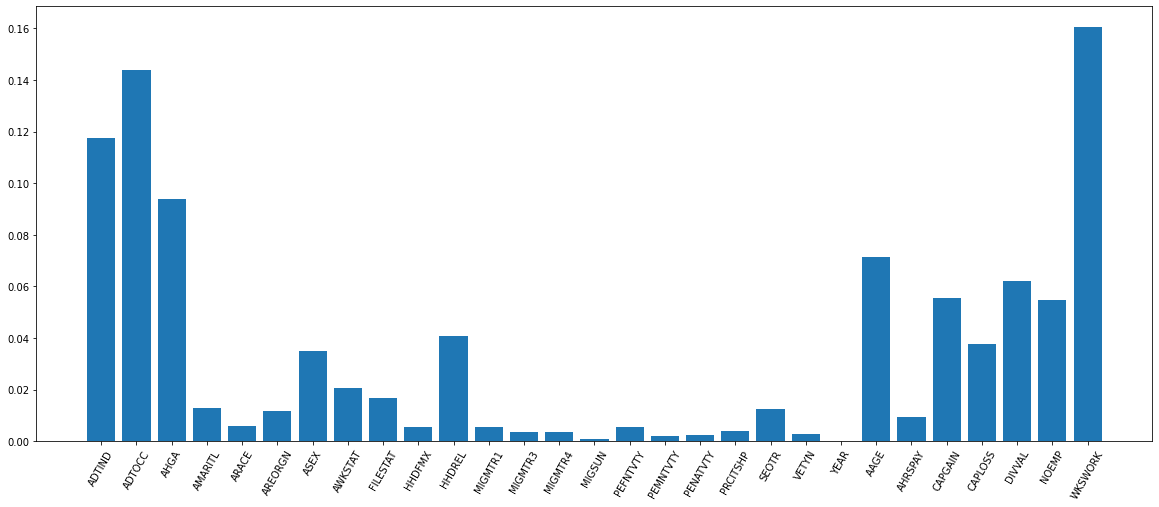

In [75]:
fig=plt.figure(figsize=(20,8))
plt.bar(string_columns+continous_columns,[val for val in best_model.bestModel.featureImportances])
plt.xticks(rotation=60)
plt.show()

In [76]:
eval_Model(predict_(best_model,test_data))

{'accuracy': 0.9132455325044281,
 'fMeasureByLabel': 0.5199417758369723,
 'weightedPrecision': 0.9435669504370989,
 'weightedRecall': 0.913245532504428}